# Nearest neighbour search

## Finding similar vectors to a query vector

- Let us consider $X$ to be a list of vectors.

- Let $X[i]$ denote the i'th document from our list of vectors.

- Given `x^q` a query document we want to find the closest vector.

$$
x^{nn} = \arg\min_{x \in  X} d(x,x^q)
$$


In [1]:
import numpy as np

def distance(x1: np.ndarray, x2: np.ndarray):
    return np.linalg.norm((x1-x2)**2)

def nearest_neighbor(X: np.ndarray, x_q: np.ndarray,
                     get_extra: bool=True):

    n_docs, n_feat = X.shape
    i_star = 0
    min_dist = np.inf
    
    x_nn = np.zeros(n_feat)
    
    for i in range(n_docs):
        current_dist = distance(x_q, X[i]) 
        if current_dist < min_dist:
            x_nn = X[i]
            min_dist = current_dist
            i_star = i
            
    if get_extra:
        return x_nn, min_dist, i_star
    else:
        return x_nn

In [2]:
np.random.seed(1234)
X   = np.random.rand(10000,100)
x_q = np.random.rand(100)

In [3]:
%time ind = np.argmin(np.linalg.norm((X-x_q)**2,axis=1)**2)

CPU times: user 7.57 ms, sys: 6.47 ms, total: 14 ms
Wall time: 12.4 ms


In [4]:
min_dist = np.linalg.norm((X-x_q)**2,axis=1)[ind]
ind, min_dist

(6628, 1.676016369531401)

In [5]:
%time x_nn, min_dist, ind2 = nearest_neighbor(X, x_q, get_extra=True)

CPU times: user 227 ms, sys: 76.2 ms, total: 303 ms
Wall time: 245 ms


In [6]:
ind2, min_dist

(6628, 1.676016369531401)

## K Nearest Neighbours


We want to find
$$
X^{Knn} = [ x^{nn_1}, \dots, x^{nn_K} ]
$$
such that


$$
 x\in X  \,\,\,\, \Rightarrow \,\,\, \forall x^{nn} \in  X^{Knn} \,\,\,\,\, d(x,x_q) \geq \max d(x,  x^{nn}) 
$$


In [7]:
list_items = [2,512,123]
sorted_indices = np.argsort(list_items)
sorted_indices

array([0, 2, 1])

In [8]:
[list_items[ind] for ind in sorted_indices] 

[2, 123, 512]

In [9]:
def sort_list_given_sorted_indices(l, sorted_indices):
    return [l[ind] for ind in sorted_indices] 

In [10]:
sort_list_given_sorted_indices(list_items, sorted_indices)

[2, 123, 512]

### Find position where `current_dist` belongs


In [98]:
dist_to_knn = [1,3,4,6]
current_dist = 3.5
dist_to_knn

[1, 3, 4, 6]

In [99]:
def find_insertion_pos(dist_to_knn, current_dist):
    if current_dist < dist_to_knn[0]:
        return 0
    
    for k in range(len(dist_to_knn)-1):
        if  current_dist > dist_to_knn[k]:
            if current_dist < dist_to_knn[k+1]:
                return k +1

In [100]:
insertion_pos = find_insertion_pos(dist_to_knn, current_dist)
print(insertion_pos)

2


##### Update list of distances

In [101]:
right_part = dist_to_knn[insertion_pos:]
right_part.pop(-1)
right_part.insert(0,current_dist)
result = dist_to_knn[0:insertion_pos] + right_part

In [102]:
result

[1, 3, 3.5, 4]

##### Alternative Update list of distances

In [103]:
dist_to_knn = [1,3,4,6]
current_dist = 3.5
dist_to_knn

[1, 3, 4, 6]

In [104]:
insertion_pos = find_insertion_pos(dist_to_knn, current_dist)
dist_to_knn[insertion_pos+1:] = dist_to_knn[insertion_pos:-1] 
dist_to_knn[insertion_pos] = current_dist

In [105]:
dist_to_knn

[1, 3, 3.5, 4]

### Algorithm for Knn

In [106]:
def inititialize_Knn(X_k: np.ndarray, x_q: np.ndarray, K:int):
    dist_to_Knn = []   # list storing distances
    X_nn = []          # list of sorted vectors
    
    for k in range(K):
        dist_to_Knn.append(distance(X_k[k],x_q))
        X_nn.append(X_k[k])
    
    sorted_indices = np.argsort(dist_to_Knn)

    dist_to_Knn = [dist_to_Knn[ind] for ind in sorted_indices] 
    X_nn  = [X_k[ind] for ind in sorted_indices] 
    return dist_to_Knn, X_nn

In [133]:
K = 10
dist_to_Knn, X_nn = inititialize_Knn(X[0:K], x_q, K)

In [134]:

def update_Knn(current_dist, dist_to_Knn, X_nn, K):

    insertion_pos                  = find_insertion_pos(dist_to_Knn, current_dist)
    X_nn[insertion_pos+1:K]        = X_nn[insertion_pos:K-1] 
    dist_to_Knn[insertion_pos+1:K] = dist_to_Knn[insertion_pos:K-1] 

    dist_to_Knn[insertion_pos] = current_dist
    X_nn[insertion_pos]        = x_nn
    
    return  dist_to_Knn, X_nn      


def K_nearest_neighbor(X: np.ndarray, x_q: np.ndarray, K:int,
                       get_extra: bool=True):

    N, n_feat = X.shape
    dist_to_Knn, X_nn = inititialize_Knn(X[0:K], x_q, K)
    
    for i in range(K, N):
        current_dist = distance(X[i], x_q)         
        if current_dist < dist_to_Knn[-1]:
            dist_to_Knn, X_nn = update_Knn(current_dist, dist_to_Knn, X_nn, K)       

    if get_extra:
        return X_nn, dist_to_Knn
    else:
        return X_nn


In [135]:
%time X_nn, dist_to_Knn = K_nearest_neighbor(X, x_q, K=10, get_extra=True)

CPU times: user 208 ms, sys: 58.7 ms, total: 267 ms
Wall time: 224 ms


In [136]:
dist_to_Knn

[1.676016369531401,
 1.7467966970236957,
 1.752387930300928,
 1.757646876648462,
 1.764759807648174,
 1.7772958950113709,
 1.7871631631153262,
 1.8388565032211817,
 1.8462364438362342,
 1.859783943496062]

In [137]:
distance(X_nn[0], x_q)

1.676016369531401

In [138]:
%time ind = np.argmin(np.linalg.norm((X - x_q)**2,axis=1))
distance(X[ind], x_q)

CPU times: user 4.87 ms, sys: 1.59 ms, total: 6.46 ms
Wall time: 4.3 ms


1.676016369531401

# Cosine similarity

In [ ]:
def cos_similairty(p,q):
    return np.dot(p,q)/(np.linalg.norm(p)*np.linalg.norm(q))

In [146]:
def dot_similairty(p,q):
    return np.dot(p,q)

In [169]:
p = np.array([1,0,0,0,5,4,0,0,1,0,0,0,0])
q = np.array([3,1,0,0,2,0,0,1,0,1,0,0,0])

In [170]:
dot_similairty(p,q)

13

In [153]:
p2 = p*2
q2 = q*2

In [155]:
p2

array([6, 2, 0, 0, 4, 0, 0, 2, 0, 2, 0, 0, 0])

In [156]:
q2

array([6, 2, 0, 0, 4, 0, 0, 2, 0, 2, 0, 0, 0])

In [176]:
p2 = p*2
q2 = q*2
dot_similairty(p2,q2)

52

### Normalizing vectors

What happens if you normalize?

In [177]:
p2 = p/np.linalg.norm(p)
q2 = q/np.linalg.norm(q)

In [178]:
dot_similairty(p,q)

13

# Improving seach: KD-Tree


Organize the space into axis aligned boxes.


We will take a table 

In [209]:
from matplotlib import pyplot as plt

In [210]:
def dist(x,y):
    return np.sqrt(np.linalg.norm((x-y)**2))

def closest_point(all_points, query_point, dist):
    closest_point_    = None
    closest_distance_ = np.inf
    
    for current_point in all_points:
        current_distance = dist(query_point, current_point)
        
        if  current_distance < closest_distance_:
            closest_distance_ = current_distance
            closest_point_    = current_point
            
    return closest_point_, closest_distance_

In [211]:
X = np.array([[1,1],[0,3],[4,3],[0,0],[1,5],[6,1],[-2,1],[4,4],[2,1],[-1,0]])
x_components = [x[0] for x in X]
y_components = [x[1] for x in X]
query = np.array([1,3])

Query: [1 3]
Closest to query: [0 3]


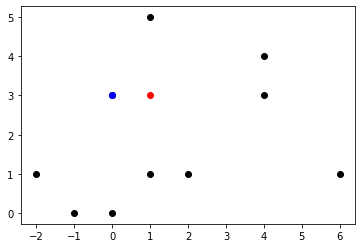

In [213]:
closest_to_query, _ = closest_point(X, query, dist)
print("Query: {}\nClosest to query: {}".format(query,closest_to_query))
plt.scatter(x_components, y_components, color="black")
plt.scatter(query[0], query[1], color="red")
plt.scatter(closest_to_query[0], closest_to_query[1], color="blue", linewidths=1, marker="o")

In [215]:

def closest_point_(all_points, new_point):
    best_point = None
    best_dist  = None
    
    for current_point in all_points:
        current_distance = distance(new_point, current_point)
        
        if best_distance is None or current_distance<best_distance:
            best_distance = current_distance
            best_point = current_point
            
    return best_point

- sort all the points by an axis (each iteration change the axis)
- find the median, split the points


To change the axis use a modulus operation


In [235]:
n_axis = 3
0%3,1%3,2%3,3%3

(0, 1, 2, 0)

In [381]:
k = 2

def build_kdtree(points, depth=0):
    n = len(points)
    
    if n<=0:
        return None
    
    axis = depth%k
    sorted_points = sorted(points, key= lambda point:point[axis])

    midpoint = int(n/2)
    
    return { 
             "point": sorted_points[midpoint],
             "left":build_kdtree(sorted_points[:midpoint], depth+1),
             "right":build_kdtree(sorted_points[(midpoint+1):], depth+1)
           }



In [397]:
points = [list(x) for x in X]
points = [x for x in X]

In [398]:
points

[array([1, 1]),
 array([0, 3]),
 array([4, 3]),
 array([0, 0]),
 array([1, 5]),
 array([6, 1]),
 array([-2,  1]),
 array([4, 4]),
 array([2, 1]),
 array([-1,  0])]

In [422]:
kd_tree = build_kdtree(points)
kd_tree

{'point': array([1, 5]),
 'left': {'point': array([-2,  1]),
  'left': {'point': array([0, 0]),
   'left': {'point': array([-1,  0]), 'left': None, 'right': None},
   'right': None},
  'right': {'point': array([1, 1]),
   'left': {'point': array([0, 3]), 'left': None, 'right': None},
   'right': None}},
 'right': {'point': array([4, 3]),
  'left': {'point': array([6, 1]),
   'left': {'point': array([2, 1]), 'left': None, 'right': None},
   'right': None},
  'right': {'point': array([4, 4]), 'left': None, 'right': None}}}

In [425]:
import pprint
pp = pprint.PrettyPrinter()
pp.pprint(kd_tree)

{'left': {'left': {'left': {'left': None,
                            'point': array([-1,  0]),
                            'right': None},
                   'point': array([0, 0]),
                   'right': None},
          'point': array([-2,  1]),
          'right': {'left': {'left': None,
                             'point': array([0, 3]),
                             'right': None},
                    'point': array([1, 1]),
                    'right': None}},
 'point': array([1, 5]),
 'right': {'left': {'left': {'left': None,
                             'point': array([2, 1]),
                             'right': None},
                    'point': array([6, 1]),
                    'right': None},
           'point': array([4, 3]),
           'right': {'left': None, 'point': array([4, 4]), 'right': None}}}


In [426]:

def distance(x1: np.ndarray, x2: np.ndarray):
    return np.linalg.norm((x1-x2)**2)

In [441]:

def closer_distance(pivot, p1, p2):
    if p1 is None:
        return p2
    if p2 is None:
        return p1
    
    d1 = distance(pivot, p1)
    d2 = distance(pivot, p2)
    
    if d1 <d2:
        return p1
    else: 
        return p2
    
    
def kdtree_closest_point(root, point, depth=0):
    if root is None:
        return None
    
    axis = depth%k

    next_branch     = None
    opposite_branch = None
    
    #import pdb;pdb.set_trace()
    #print(axis, type(axis), type(root))
    #print( point[axis],root["point"])
    
    if point[axis] < root["point"][axis]:
        next_branch = root["left"]
        oposite_branch = root["right"]
    else:
        next_branch = root["right"]
        opposite_branch = root["left"]
        
    best = closer_distance(point,
                           kdtree_closest_point(next_branch,
                                                point, 
                                                depth+1),
                           root["point"])
    
    if  distance(point, best) > abs(point[axis] - root["point"][axis]):
    #if  distance(point, best) > distance(point, root["point"]):
        best = closer_distance(point,
                               kdtree_closest_point(next_branch,
                                                point, 
                                                depth+1),
                               best)
       
    return best
    

In [442]:
q = query
q

array([1, 3])

In [443]:
kdtree_closest_point(kd_tree, q)

array([1, 5])

Query: [1 3]
Closest to query: [0 3]


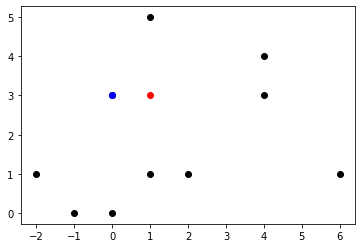

In [430]:
closest_to_query, _ = closest_point(X, query, dist)
print("Query: {}\nClosest to query: {}".format(query,closest_to_query))
plt.scatter(x_components, y_components, color="black")
plt.scatter(query[0], query[1], color="red")
plt.scatter(closest_to_query[0], closest_to_query[1], color="blue", linewidths=1, marker="o")

### kdtree in sklearn

In [197]:
np.random.seed(1234)
X = np.random.rand(1000000,10).astype(np.float32)
x = np.random.rand(1,10).astype(np.float32)

In [198]:
%time distances =  np.mean((X-x)**2,1)

CPU times: user 56.5 ms, sys: 15.6 ms, total: 72.1 ms
Wall time: 70.4 ms


In [199]:
%time closest = np.argmin(np.mean((X-x)**2,1))
print("\nclosest row from x is {}".format(closest))

CPU times: user 46.7 ms, sys: 7.57 ms, total: 54.3 ms
Wall time: 52.5 ms

closest row from x is 888194


In [200]:
import sklearn
from sklearn import *

In [201]:
%time tree = sklearn.neighbors.KDTree(X, leaf_size=1_000_000)

CPU times: user 28.7 ms, sys: 4.68 ms, total: 33.4 ms
Wall time: 31.5 ms


In [202]:
%time distance_to_closest, closest_kdtree = tree.query(x,k=1)

CPU times: user 14.7 ms, sys: 1.17 ms, total: 15.9 ms
Wall time: 14.2 ms


In [203]:
print("\nclosest row from x is {}".format(closest_kdtree[0][0]))


closest row from x is 888194
